In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Scikit-Learn

In [2]:
iris = load_iris()

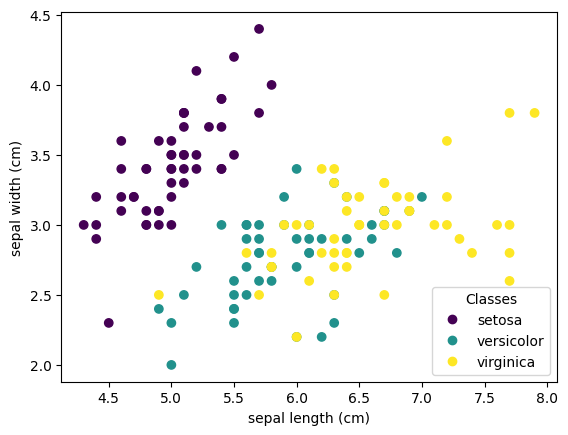

In [3]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)


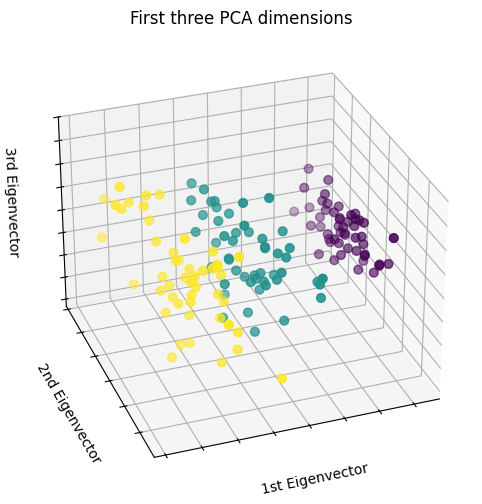

In [4]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

In [5]:
target_strings: list[str] = []
for i in iris["target"]:
    target_strings.append(
        "setosa" if i == 0 else "versicolor" if i == 1 else "virginica"
    )

In [6]:
df: pd.DataFrame = pd.DataFrame(
    {
        "sepal_length" : iris["data"][:,0],
        "sepal_width" : iris["data"][:,1],
        "petal_length" : iris["data"][:,2],
        "petal_width" : iris["data"][:,3],
        "target_val" : iris["target"],
        "target_string" : target_strings
    }
)
df

,sepal_length,sepal_width,petal_length,petal_width,target_val,target_string
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [7]:
X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris["target"])

In [8]:
log_regr = LogisticRegression()
model_log_regr = log_regr.fit(
    X_train, y_train
)

In [9]:
preds_log_regr = model_log_regr.predict(X_test)

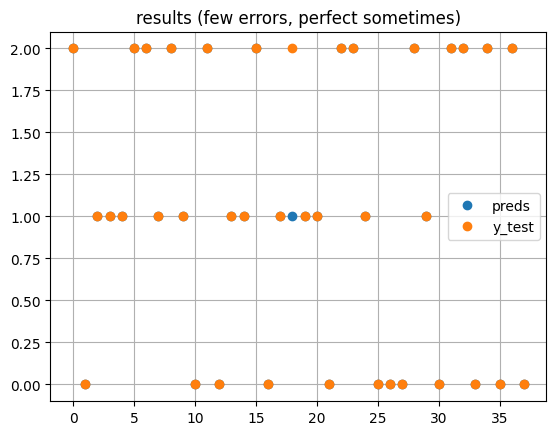

In [10]:
fig, ax = plt.subplots()

ax.plot(list(preds_log_regr), linestyle="", marker="o", label="preds")
ax.plot(list(y_test), linestyle="", marker="o", label="y_test")
ax.set_title("results (few errors, perfect sometimes)")
ax.grid()
ax.legend()

# PyTorch

In [19]:
import torch

import torch.nn as nn

In [20]:
device: str = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device

'mps'

In [21]:
X_train_tensor, y_train_tensor = (
    torch.tensor(X_train, dtype=torch.float32).to(device=device),
    torch.tensor(y_train, dtype=torch.long).to(device=device)
)

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [23]:
def fit(model: NeuralNetwork):
    epochs = 400
    loss_arr = []
    loss_fn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.002)

    for _ in range(epochs):
        ypred = model(X_train_tensor)
        loss = loss_fn(ypred, y_train_tensor)
        loss_arr.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()

    plt.plot(loss_arr)
    plt.show()

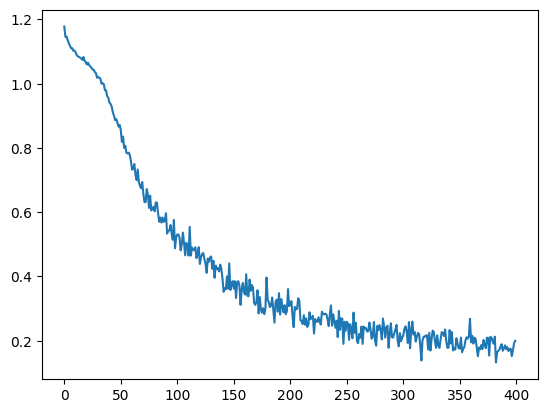

In [24]:
model = NeuralNetwork().to(device=device)
fit(model=model)

In [25]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device=device)
y_test_pred = model(X_test_tensor)
_y_test = torch.argmax(y_test_pred, dim=1)

In [26]:
print("Accuracy:", accuracy_score(_y_test.cpu(), y_test))
print("Confusion Matrix:\n\n", confusion_matrix(_y_test.cpu(), y_test))

Accuracy: 1.0
Confusion Matrix:

 [[12  0  0]
 [ 0 12  0]
 [ 0  0 14]]
